## Plotting

In [24]:
from optiwindnet.api import WindFarmNetwork
import numpy as np

### Create a sample network

In [46]:
# all coordinates are sequences of (x, y) pairs
# if input coordinates are in arrays X and Y, use `np.hstack((X, Y))`
border = np.array( # coordinate sequence defines the polygon, last-first segment implicit
    [[1951, 200], [1951, 1383], [386, 1383], [650, 708], [624, 678],
     [4, 1036], [4, 3], [1152, 3], [917, 819], [957, 854]],
    dtype=float)

border = border[::-1]
obstacles = [
    # - obstacles must be strictly inside the border polygon
    # - undefined behavior if obstacles and border overlap
    # first obstacle
    np.array([[1540, 920], [1600, 940], [1600, 1150], [700, 1200]]),
    # [second obstacle] ...
]

substations = np.array([[696, 1063],], dtype=float)
turbines = np.array(
    [[1940, 279], [1920, 703], [1475, 696], [1839, 1250],
     [1277, 1296], [442, 1359], [737, 435], [1060, 26],
     [522, 176], [87, 35], [184, 417], [71, 878]],
    dtype=float
)

In [54]:
wfn = WindFarmNetwork(turbines=turbines, substations=substations, obstacles=obstacles)

border None
obstacles [array([[1540,  920],
       [1600,  940],
       [1600, 1150],
       [ 700, 1200]])]


Plots (gplot)

<Axes: >

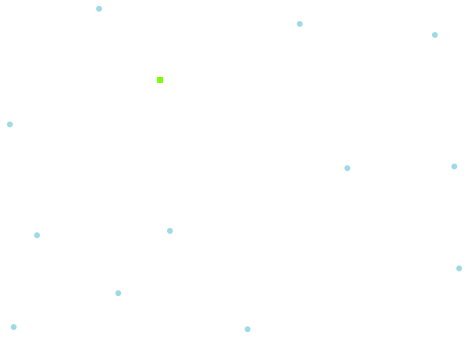

In [55]:
wfn.plot_location()

<Axes: >

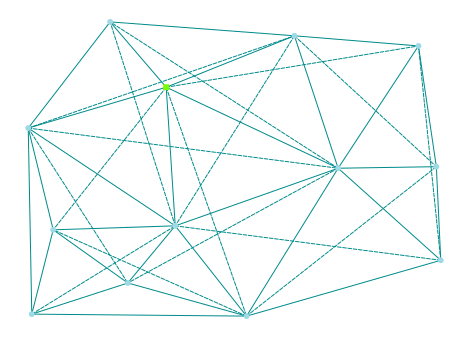

In [56]:
wfn.plot_available_links()

<Axes: >

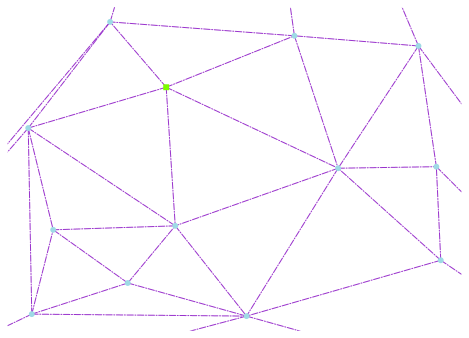

In [57]:
wfn.plot_navigation_mesh()

svgplots

Optimize

In [58]:
wfn.optimize()

cables: [(10, 1)]


array([(11, 10, 474.64723743, 5.,  True, 0, 474.64723743),
       (11,  5, 607.45534815, 6., False, 0, 607.45534815),
       (-1,  4, 625.97923288, 5., False, 0, 625.97923288),
       (-1,  5, 390.04102348, 7., False, 0, 390.04102348),
       ( 3,  4, 563.87941973, 4.,  True, 0, 563.87941973),
       ( 3,  1, 552.96473667, 3.,  True, 0, 552.96473667),
       ( 0,  1, 424.47143602, 1.,  True, 0, 424.47143602),
       ( 2,  1, 445.05505277, 1., False, 0, 445.05505277),
       ( 8, 10, 415.12046444, 3.,  True, 0, 415.12046444),
       ( 8,  6, 336.60956611, 2.,  True, 0, 336.60956611),
       ( 9, 10, 394.12307722, 1.,  True, 0, 394.12307722),
       ( 6,  7, 521.16216286, 1., False, 0, 521.16216286)],
      dtype=[('src', '<i8'), ('tgt', '<i8'), ('length', '<f8'), ('load', '<f8'), ('reverse', '?'), ('cable', '<i8'), ('cost', '<f8')])

<Axes: >

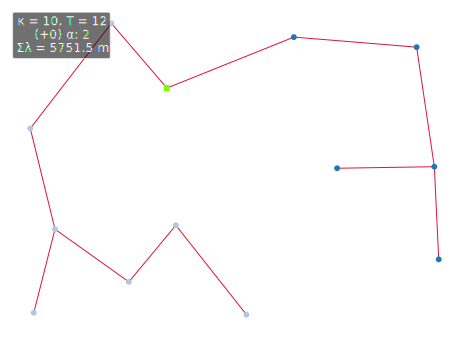

In [59]:
wfn.plot_selected_links()

<Axes: >

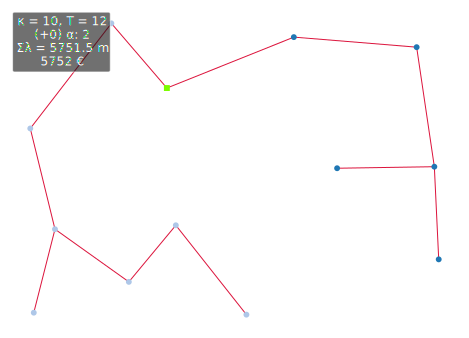

In [60]:
wfn.plot()

### Using Matplotlib-based `gplot()`

Matplotlib can produce inline plots in Jupyter notebooks using different formats. The default is PNG and it works ok, but the embedding of the binary image in the text-only `.ipynb` file makes them big and generates many false-positives when searching for short strings (outside of Jupyter, e.g. `ripgrep`).

By using the SVG format, the notebooks are smaller in size and the false-positives are avoided. In addition, the vector-based figures saved within the notebook can be exported as editable SVG files without needing to run the notebook again. On JupyterLab:
- Shift+Right_click -> "Open image in new tab"
- Menu "File" -> "Save"

The 'svg.fonttype' rcParams entry set to 'none' prevents Matplotlib from converting text to paths, which also helps with reducing image sizes (the drawback being possible visual differences if the fonts used at creation are not available when visualizing the figures).

One drawback of SVG plots in Jupyter notebooks is having to mark the notebook as **Trusted** to display the figures when opening it in a different computer than the one that created it. In JupyterLab <Ctrl+Shift+C>, search for 'trust' and select "Trust Notebook".

In [10]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']
plt.rcParams['svg.fonttype'] = 'none'

The Matplotlib-based plotting functions in OptiWindNet are `gplot()` and `pplot()`.

`gplot()` returns a plt.Axes object, which can be used to adjust many aspects of the figure, or to save it to a file in a diversity of formats, e.g.:
```python
ax.figure.savefig('myfig.pdf')
```

It is also possible to provide a pre-existing plt.Axes object within a matplotlib figure:

<Axes: >

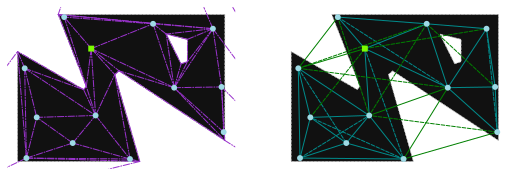

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, facecolor='none', figsize=(9, 3))

wfn.plot_navigation_mesh(ax=ax1)
wfn.plot_available_links(ax=ax2)

`pplot(P, A)` is only useful for tinkering with the pathfinding algorithm and most OptiWindNet users will not need to use it. Plotting the available edges graph **A** is useful mainly for debugging.

The main advantage of `gplot()` over `svgplot()` are node tags and figure legends:

<Axes: >

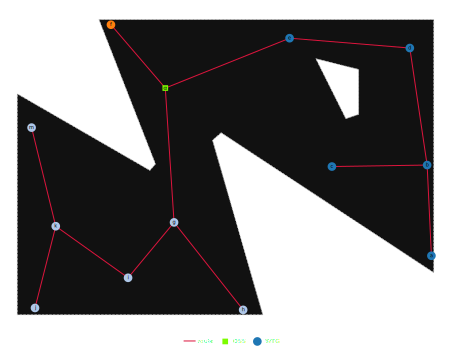

In [12]:
wfn.plot(node_tag='label', infobox=False, legend=True)

The nodes can also be tagged by the power they export towards the substation:

<Axes: >

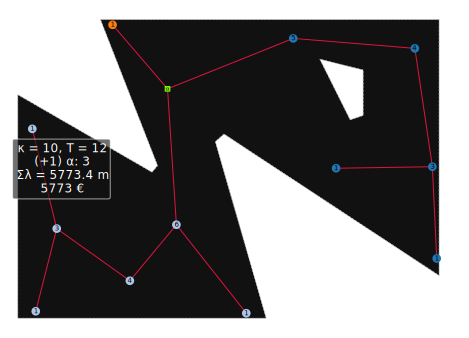

In [13]:
wfn.plot(node_tag='load')

### Using `svgplot()`

Most plots in the examples are created with `svgplot()`. The figures are visually similar to the ones generated with `gplot`, except for the lack of the `node_tag` and `legend` options. The infobox position here is fixed to the lower-right corner, while `gplot()` tries to place it in the least-obstrusive position.

The advantage of a SVG created by `svgplot()` over the one produced by Matplotlib is its smaller and simpler structure, which is also better suited for further editing (e.g. using Inkscape).

In [14]:
wfn.svgplot()

AttributeError: 'WindFarmNetwork' object has no attribute 'svgplot'

The `svgplot()` does not create an inline image upon being called, the SVG is displayed when the object returned by the `svgplot()` call is the cell output. To display figures created within the code cell, use `IPython.display.display`.

To save to a file:
```python
svgplot(G).save('myfig.svg')
```

In [ ]:
from IPython.display import display

In [ ]:
for cap in [9, 7, 5]:
    wfn_loop = WindFarmNetwork.upload_L(L=L, cables_capacity=cap, router=router)
    wfn_loop.optimize()
    display(wfn_loop.svgplot())

### Dark and Light plotting themes

Both `gplot()` and `svgplot()` try to match the colors used in the figure to the operating system's theme via Python package `darkdetect`. This package detects the system's theme and not JupyterLab's theme, so it may lead no non-ideal results if they do not match.

The example notebooks are created from a dark-themed system, but the figures might have a light background when the notebooks are run on a different computer.

The theme can be enforced programmatically by setting the argument `dark` to `True` or `False`:

In [ ]:
wfn.svgplot(dark=False)

### Rotated locations

Each location included in OptiWindNet has a graph attribute called 'landscape_angle'.

In [ ]:
L.graph['landscape_angle']

This is the angle that will rotate the site to be in the best orientation for a landscape figure. If the user prefers the orientation to be with the north always up, the argument `landscape` can be used. Alternatively, 'landscape_angle' could be set to 0.

In [ ]:
wfn.svgplot(landscape=False)